# Analysing DNA Sequences and Finding Protein-Coding Regions

Gene: Human Insulin

## Downloading Sequence Data from Entrez Database

In [ ]:
# Library
from Bio import Entrez, SeqIO
from Bio.SeqRecord import SeqRecord

In [ ]:
# Always provide your email when using NCBI services
Entrez.email = "<your_email@example.com"

In [ ]:
# Fetch the human insulin gene sequence
handle = Entrez.efetch(db="nucleotide", id="NM_000207", rettype="fasta", retmode="text")
record: SeqRecord = SeqIO.read(handle, "fasta")
handle.close()

print(f"Sequence ID: {record.id}")
print(f"Description: {record.description}")
print(f"Length: {len(record.seq)} bp")

Sequence ID: NM_000207.3
Description: NM_000207.3 Homo sapiens insulin (INS), transcript variant 1, mRNA
Length: 465 bp


## Basic Sequence Analysis

In [4]:
record.seq

Seq('AGCCCTCCAGGACAGGCTGCATCAGAAGAGGCCATCAAGCAGATCACTGTCCTT...AGC')

In [ ]:
print(record.seq)

AGCCCTCCAGGACAGGCTGCATCAGAAGAGGCCATCAAGCAGATCACTGTCCTTCTGCCATGGCCCTGTGGATGCGCCTCCTGCCCCTGCTGGCGCTGCTGGCCCTCTGGGGACCTGACCCAGCCGCAGCCTTTGTGAACCAACACCTGTGCGGCTCACACCTGGTGGAAGCTCTCTACCTAGTGTGCGGGGAACGAGGCTTCTTCTACACACCCAAGACCCGCCGGGAGGCAGAGGACCTGCAGGTGGGGCAGGTGGAGCTGGGCGGGGGCCCTGGTGCAGGCAGCCTGCAGCCCTTGGCCCTGGAGGGGTCCCTGCAGAAGCGTGGCATTGTGGAACAATGCTGTACCAGCATCTGCTCCCTCTACCAGCTGGAGAACTACTGCAACTAGACGCAGCCCGCAGGCAGCCCCACACCCGCCGCCTCCTGCACCGAGAGAGATGGAATAAAGCCCTTGAACCAGC


### Complement

In [6]:
record.seq.complement()

Seq('TCGGGAGGTCCTGTCCGACGTAGTCTTCTCCGGTAGTTCGTCTAGTGACAGGAA...TCG')

### Reverse Complement

In [7]:
record.seq.reverse_complement()

Seq('GCTGGTTCAAGGGCTTTATTCCATCTCTCTCGGTGCAGGAGGCGGCGGGTGTGG...GCT')

### Nucleotide Count

In [10]:
a_count = record.seq.count('A')
t_count = record.seq.count('T')
g_count = record.seq.count('G')
c_count = record.seq.count('C')

print(f"Nucleotide Composition:")
print(f"A: {a_count} ({a_count / len(record.seq):.2%})")
print(f"T: {t_count} ({t_count / len(record.seq):.2%})")
print(f"G: {g_count} ({g_count / len(record.seq):.2%})")
print(f"C: {c_count} ({c_count / len(record.seq):.2%})")

Nucleotide Composition:
A: 91 (19.57%)
T: 77 (16.56%)
G: 141 (30.32%)
C: 156 (33.55%)


In [11]:
# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\shres\AppData\Local\Temp\ipykernel_16076\1269310117.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[a_count, t_count, g_count, c_count], y=['A', 'T', 'G', 'C'], palette="viridis")


<Axes: >

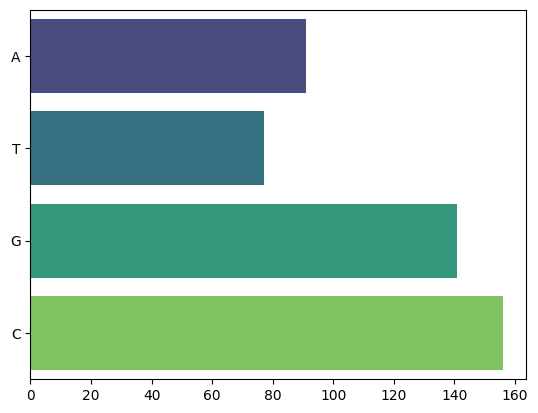

In [21]:
sns.barplot(x=[a_count, t_count, g_count, c_count], y=['A', 'T', 'G', 'C'], palette="viridis")

### Calculate GC Content

In [9]:
from Bio.SeqUtils import gc_fraction

gc_content = gc_fraction(record.seq)

print(f"GC Content: {gc_content:.2%}")

GC Content: 63.87%


## Finding Open Reading Frames (ORFs)

In [23]:
def find_orfs(sequence, min_protein_length=100):
    """Find all ORFs in a DNA sequence"""
    orfs = []

    # Check all three reading frames
    for frame in range(3):
        # Get the sequence for this frame
        seq_frame = sequence[frame:]

        # Translate to protein
        protein = seq_frame.translate(to_stop=False)
        
        # Find all start codons
        start = 0
        while True:
            start = str(protein).find('M', start)
            if start == -1:
                break

            # Find the next stop codon
            stop = start + 1
            while stop < len(protein) and protein[stop] != '*':
                stop += 1

            # If we found a complete ORF
            if stop < len(protein):
                orf_length = stop - start
                if orf_length >= min_protein_length:
                    orfs.append({
                        'frame': frame,
                        'start': frame + start * 3,
                        'stop': frame + stop * 3,
                        'length': orf_length,
                        'protein': str(protein[start:stop])
                    })

            start += 1
            
    return orfs

In [24]:
# Find ORFs
orfs = find_orfs(record.seq, min_protein_length=50)
orfs

c:\Users\shres\Projects\BioPy\.venv\Lib\site-packages\Bio\Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


[{'frame': 2,
  'start': 59,
  'stop': 389,
  'length': 110,
  'protein': 'MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN'},
 {'frame': 2,
  'start': 71,
  'stop': 389,
  'length': 106,
  'protein': 'MRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN'}]

In [28]:
print(f"Found {len(orfs)} ORFs (minimum 50 amino-acids)")
for i, orf in enumerate(orfs[:3], 1):
    print(f"\nORF {i}:")
    print(f"    Frame: {orf['frame']}")
    print(f"    Position: {orf['start']} - {orf['stop']}")
    print(f"    Protein Length: {orf['length']} aa")
    print(f"    Protein Sequence: {orf['protein'][:50]}...")

Found 2 ORFs (minimum 50 amino-acids)

ORF 1:
    Frame: 2
    Position: 59 - 389
    Protein Length: 110 aa
    Protein Sequence: MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFY...

ORF 2:
    Frame: 2
    Position: 71 - 389
    Protein Length: 106 aa
    Protein Sequence: MRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKT...


## Visualize ORF Locations

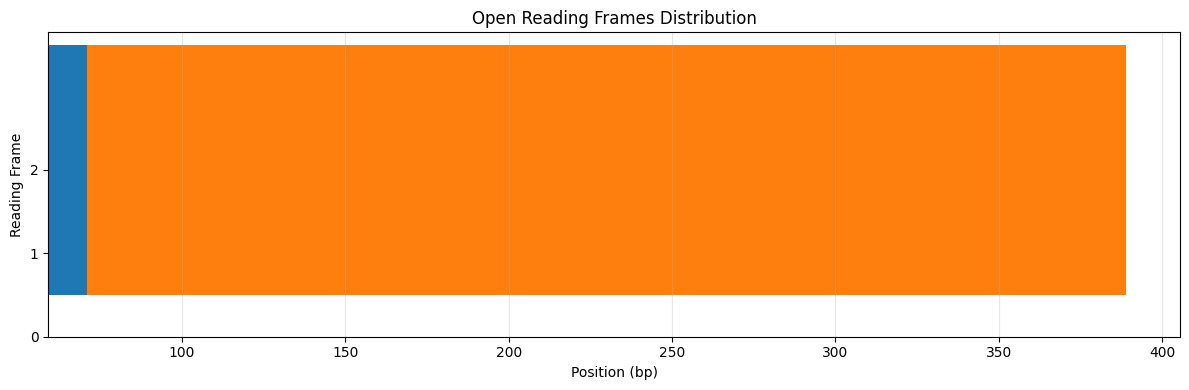

In [ ]:
import matplotlib.pyplot as plt

if orfs:
    plt.figure(figsize=(12, 4))

    for orf in orfs:
        y_pos = orf['frame']
        plt.barh(y_pos, orf['stop'] - orf['start'], left=orf['start'], height=3)

    plt.xlabel('Position (bp)')
    plt.ylabel('Reading Frame')
    plt.title('Open Reading Frames Distribution')
    plt.yticks([0, 1, 2])
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('orf_distribution.png')
    plt.show()

## Protein Analysis

In [29]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Analyze the longest ORF
if orfs:
    longest_orf = max(orfs, key=lambda x: x['length'])
    protein_seq = longest_orf['protein']

    analyzer = ProteinAnalysis(protein_seq)

    print(f"\nProtein Analysis for longest ORF:")
    print(f"Molecular Weight: {analyzer.molecular_weight():.2f} Da")
    print(f"Theoretical pI: {analyzer.isoelectric_point():.2f}")
    print(f"Instability Index: {analyzer.instability_index():.2f}")
    print(f"Aromaticity: {analyzer.aromaticity():.3f}")

    # Amino Acid Composition
    aa_comp = analyzer.get_amino_acids_percent()
    print("\nTop 5 amino acids:")
    for aa, percent in sorted(aa_comp.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"    {aa}: {percent:.2%}%")


Protein Analysis for longest ORF:
Molecular Weight: 11980.79 Da
Theoretical pI: 5.22
Instability Index: 40.33
Aromaticity: 0.082

Top 5 amino acids:
    L: 18.18%%
    G: 10.91%%
    A: 9.09%%
    E: 7.27%%
    Q: 6.36%%


c:\Users\shres\Projects\BioPy\.venv\Lib\site-packages\Bio\SeqUtils\ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(


## Save Results

In [30]:
# Save the longest protein sequence to a file
if orfs:
    with open('protein_sequence.fasta', 'w') as file:
        file.write(f">Longest_ORF|Length_{longest_orf['length']}\n")
        file.write(f"{protein_seq}\n")

    print("\nProtein sequence saved to protein_sequence.fasta")


Protein sequence saved to protein_sequence.fasta


## Sequence Alignment and Motif Finding

### Pairwise Sequence Alignment

In [33]:
from Bio import Entrez, SeqIO, AlignIO, pairwise2
from Bio.Align import substitution_matrices
from Bio.pairwise2 import format_alignment

In [34]:
# Human Insulin
handle = Entrez.efetch(db='nucleotide', id='NM_000207', rettype='fasta', retmode='text')
human_insulin = SeqIO.read(handle, 'fasta')
handle.close()

In [35]:
human_insulin

SeqRecord(seq=Seq('AGCCCTCCAGGACAGGCTGCATCAGAAGAGGCCATCAAGCAGATCACTGTCCTT...AGC'), id='NM_000207.3', name='NM_000207.3', description='NM_000207.3 Homo sapiens insulin (INS), transcript variant 1, mRNA', dbxrefs=[])

In [36]:
# Mouse Insulin
handle = Entrez.efetch(db='nucleotide', id='NM_008387', rettype='fasta', retmode='text')
mouse_insulin = SeqIO.read(handle, 'fasta')
handle.close()

In [37]:
mouse_insulin

SeqRecord(seq=Seq('GGGGACCCAGTAACCACCAGCCCTAAGTGATCCGCTACAATCAAAAACCATCAG...AAA'), id='NM_008387.5', name='NM_008387.5', description='NM_008387.5 Mus musculus insulin II (Ins2), transcript variant 2, mRNA', dbxrefs=[])

#### Global Alignment (Needleman-Wunsch)

In [40]:
# Perform global alignment
alignments = pairwise2.align.globalxx(
    human_insulin.seq,
    mouse_insulin.seq,
    one_alignment_only=True
)

In [39]:
if alignments:
    alignment = alignments[0]

    # Calculate alignment statistics
    matches = sum(1 for a, b in zip(alignment.seqA, alignment.seqB) if a == b and a != '-')
    mismatches = sum(1 for a, b in zip(alignment.seqA, alignment.seqB) if a != b and a != '-' and b != '-')
    gaps = alignment.seqA.count('-') + alignment.seqB.count('-')
    alignment_length = len(alignment.seqA)
    identity = (matches / alignment_length) * 100

    print(f"\nAlignment Score: {alignment.score}")
    print(f"Alignment Length: {alignment_length}")
    print(f"Matches: {matches}")
    print(f"Mismatches: {mismatches}")
    print(f"Gaps: {gaps}")
    print(f"Identity: {identity:.2f}%")

    # Show a portion of the alignment
    print("\nAlignment preview (first 1000 positions):")
    print(format_alignment(*alignment, full_sequences=False)[:1000])


Alignment Score: 376.0
Alignment Length: 574
Matches: 376
Mismatches: 0
Gaps: 198
Identity: 65.51%

Alignment preview (first 1000 positions):
AG----CCC--T--CCAGG--A-C---A-G-GC-T--GC-A---TCAGAAGAGG-CCATCA--A-GCAG-AT--C--A-CTGTCC---TTC-T-G---C--CATGGCCCTGTGGATGCGCCT-CCTGCCCCTGCTGGCGC-TGCTGGC--CCTCTGGGGA--CCTG-ACCC-AGCCGCAGC-CTTTGTG--AAC-CAA-CACCTGT-GC-GGCT-CAC-ACCTGGTGGAAG-CTCTCTACCTAG-TGTGC-GGGGAA-CGA-GGCTTCTTCTACACACCCAA-GA-CCCGCCGG-GA-G-GCAGAGGACCTGCAG---GTGGGGCAGG----TGGAGCTGGGCG-GG-GGCCCTGGTGCAGGCAG----CCTG-CAGC-CCTTGGCC-CTGGAGG-GGTCCCT-GCAGAAGCGTGGCATTGTGGA-A-CAA-TGCTGT-ACCAGCATCTGCTCCCTCTACCAGCTGGAGAACTACTGCAACTAGACGCAGCC-CGCAGGC-AGCCCCACAC-CCG--CCGCCTCCTGCACCGAGAGAGATGGAATAAAGC-CCTT-GAACC--AGC--------
 |    |||  |  |||    | |   | | |  |  || |   ||| || |   ||||||  | |||| |   |  | || |||   ||  | |   |  |||||||||||||||||| || ||||||||||||||| | ||||  |  ||||| ||||  ||   |||| | || |||  |||| ||  ||  | | ||||| | |  || | | | ||||||||| || |||||||||| | ||||  |||| | ||  |||||||||||||||||| |

#### Local Alignment (Smith-Waterman)

In [41]:
# Perform local alignment to find conserved regions
local_alignments = pairwise2.align.localxx(
    human_insulin.seq,
    mouse_insulin.seq,
    one_alignment_only=True
)

In [42]:
if local_alignments:
    local_alignment = local_alignments[0]

    print(f"Local Alignment Score: {local_alignment.score}")
    print(f"Best local alignment region (first 1000 positions):")
    print(format_alignment(*local_alignment, full_sequences=False)[:1000])

Local Alignment Score: 376.0
Best local alignment region (first 1000 positions):
2 G----CCC--T--CCAGG--A-C---A-G-GC-T--GC-A---TCAGAAGAGG-CCATCA--A-GCAG-AT--C--A-CTGTCC---TTC-T-G---C--CATGGCCCTGTGGATGCGCCT-CCTGCCCCTGCTGGCGC-TGCTGGC--CCTCTGGGGA--CCTG-ACCC-AGCCGCAGC-CTTTGTG--AAC-CAA-CACCTGT-GC-GGCT-CAC-ACCTGGTGGAAG-CTCTCTACCTAG-TGTGC-GGGGAA-CGA-GGCTTCTTCTACACACCCAA-GA-CCCGCCGG-GA-G-GCAGAGGACCTGCAG---GTGGGGCAGG----TGGAGCTGGGCG-GG-GGCCCTGGTGCAGGCAG----CCTG-CAGC-CCTTGGCC-CTGGAGG-GGTCCCT-GCAGAAGCGTGGCATTGTGGA-A-CAA-TGCTGT-ACCAGCATCTGCTCCCTCTACCAGCTGGAGAACTACTGCAACTAGACGCAGCC-CGCAGGC-AGCCCCACAC-CCG--CCGCCTCCTGCACCGAGAGAGATGGAATAAAGC-CCTT-GAACC--AG--C
  |    |||  |  |||    | |   | | |  |  || |   ||| || |   ||||||  | |||| |   |  | || |||   ||  | |   |  |||||||||||||||||| || ||||||||||||||| | ||||  |  ||||| ||||  ||   |||| | || |||  |||| ||  ||  | | ||||| | |  || | | | ||||||||| || |||||||||| | ||||  |||| | ||  |||||||||||||||||| | |  |||||| | || | |  |||||||  ||    ||  ||||      ||||||| || | || 

### Protein Sequence Alignment with Scoring Matrix 

In [43]:
# Translate coding sequences to protein
from Bio.Seq import Seq

In [44]:
# Extract Coding Sequence - for insulin, we need to find the longest open reading frame
def get_longest_orf_protein(seq_record):
    """Get protein from longest open reading frame"""
    seq = seq_record.seq
    best_protein = None
    max_length = 0

    for frame in range(3):
        protein = seq[frame:].translate(to_stop=False)

        # Find ORF starting with M (start codon)
        for i, aa in enumerate(protein):
            if aa == 'M':
                # Find stop codon
                stop_pos = str(protein[i:]).find('*')
                if stop_pos != -1:
                    orf_protein = protein[i:i+stop_pos]
                    if len(orf_protein) > max_length:
                        max_length = len(orf_protein)
                        best_protein = orf_protein
    
    return best_protein

In [45]:
human_protein = get_longest_orf_protein(human_insulin)
human_protein

c:\Users\shres\Projects\BioPy\.venv\Lib\site-packages\Bio\Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


Seq('MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKT...YCN')

In [46]:
mouse_protein = get_longest_orf_protein(mouse_insulin)
mouse_protein

c:\Users\shres\Projects\BioPy\.venv\Lib\site-packages\Bio\Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


Seq('MALWMRFLPLLALLFLWESHPTQAFVKQHLCGSHLVEALYLVCGERGFFYTPMS...YCN')

In [48]:
# Use BLOSUM62 scoring matrix
blosum62 = substitution_matrices.load('BLOSUM62')
blosum62

Array([[ 4., -1., -2., -2.,  0., -1., -1.,  0., -2., -1., -1., -1., -1.,
        -2., -1.,  1.,  0., -3., -2.,  0., -2., -1.,  0., -4.],
       [-1.,  5.,  0., -2., -3.,  1.,  0., -2.,  0., -3., -2.,  2., -1.,
        -3., -2., -1., -1., -3., -2., -3., -1.,  0., -1., -4.],
       [-2.,  0.,  6.,  1., -3.,  0.,  0.,  0.,  1., -3., -3.,  0., -2.,
        -3., -2.,  1.,  0., -4., -2., -3.,  3.,  0., -1., -4.],
       [-2., -2.,  1.,  6., -3.,  0.,  2., -1., -1., -3., -4., -1., -3.,
        -3., -1.,  0., -1., -4., -3., -3.,  4.,  1., -1., -4.],
       [ 0., -3., -3., -3.,  9., -3., -4., -3., -3., -1., -1., -3., -1.,
        -2., -3., -1., -1., -2., -2., -1., -3., -3., -2., -4.],
       [-1.,  1.,  0.,  0., -3.,  5.,  2., -2.,  0., -3., -2.,  1.,  0.,
        -3., -1.,  0., -1., -2., -1., -2.,  0.,  3., -1., -4.],
       [-1.,  0.,  0.,  2., -4.,  2.,  5., -2.,  0., -3., -3.,  1., -2.,
        -3., -1.,  0., -1., -3., -2., -2.,  1.,  4., -1., -4.],
       [ 0., -2.,  0., -1., -3., -2., -2.

In [49]:
protein_alignments = pairwise2.align.globalds(
    human_protein,
    mouse_protein,
    blosum62,
    -10, -0.5,  # gap open, gap extend penalties
    one_alignment_only=True
)

In [50]:
if protein_alignments:
    alignment = protein_alignments[0]

    matches = sum(1 for a,b in zip(alignment.seqA, alignment.seqB) if a == b and a != '-')
    alignment_length = len(alignment.seqA) - alignment.seqA.count('-') - alignment.seqB.count('-')

    identity = (matches / alignment_length) * 100 if alignment_length > 0 else 0

    print(f"Protein Length - Human: {len(human_protein)} aa")
    print(f"Protein Length - Mouse: {len(mouse_protein)} aa")
    print(f"Alignment Score: {alignment.score}")
    print(f"Protein Identity: {identity:.2f}%")
    print("\nProtein alignment preview:")
    print(format_alignment(*alignment, full_sequences=True)[:1500])    

Protein Length - Human: 110 aa
Protein Length - Mouse: 110 aa
Alignment Score: 478.0
Protein Identity: 81.82%

Protein alignment preview:
MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN
||||||.|||||||.||...|..|||.|||||||||||||||||||||||||..|||.||.||.|.|||||||||.||.||||...||||||.|||||||||||||||||
MALWMRFLPLLALLFLWESHPTQAFVKQHLCGSHLVEALYLVCGERGFFYTPMSRREVEDPQVAQLELGGGPGAGDLQTLALEVAQQKRGIVDQCCTSICSLYQLENYCN
  Score=478



### Motif Finding - Simple Pattern Search

In [51]:
import re
from Bio.Seq import Seq

In [52]:
# Common Protein Motifs
motifs = {
    'N-glycosylation': r'N[^P][ST][^P]',
    'Protein kinase C': r'[ST].[RK]',
    'cAMP/cGMP phosphorylation': r'[RK]..[ST]',
    'Tyrosine kinase': r'[RK]..[DE]..Y',
    'PEST region': r'[PEST]{5,}',
}

In [53]:
def find_motifs(protein_seq, motif_patterns):
    """Find motif in protein sequence"""
    results = {}
    seq_str = str(protein_seq)

    for motif_name, pattern in motif_patterns.items():
        matches = []
        for match in re.finditer(pattern, seq_str):
            matches.append({
                'start': match.start() + 1,     # 1-index
                'end': match.end(),
                'sequence': match.group()
            })
        if matches:
            results[motif_name] = matches

    return results

In [54]:
# Search for motifs in human insulin protein
human_motifs = find_motifs(human_protein, motifs)

In [55]:
print('Motifs found in Human Insulin:')
if human_motifs:
    for motif_name, matches in human_motifs.items():
        print(f"\n{motif_name}:")
        for match in matches:
            print(f"    Position {match['start']}-{match['end']}: {match['sequence']}")
else:
    print('No common motif found')

Motifs found in Human Insulin:

Protein kinase C:
    Position 51-53: TPK
    Position 54-56: TRR


In [56]:
# Search for motifs in mouse insulin
mouse_motifs = find_motifs(mouse_protein, motifs)

print('Motifs found in Mouse Insulin:')
if mouse_motifs:
    for motif_name, matches in mouse_motifs.items():
        print(f"\n{motif_name}:")
        for match in matches:
            print(f"    Position {match['start']}-{match['end']}: {match['sequence']}")
else:
    print("No common motifs found")

Motifs found in Mouse Insulin:

Protein kinase C:
    Position 54-56: SRR


### Conserved Motif Analysis using Bio.motifs

In [57]:
from Bio import motifs
from Bio.Seq import Seq

In [58]:
# Create a sliding window to find conserved regions
def find_conserved_regions(seq1, seq2, window_size=10, threshold=0.8):
    """Find conserved regions between two sequences"""
    conserved_regions = []

    min_len = min(len(seq1), len(seq2))

    for i in range(min_len - window_size + 1):
        window1 = str(seq1[i:i+window_size])
        window2 = str(seq2[i:i+window_size])

        # Calculate similarity
        matches = sum(1 for a, b in zip(window1, window2) if a == b)
        similarity = matches / window_size

        if similarity >= threshold:
            conserved_regions.append({
                'position': i + 1,
                'sequence': window1,
                'similarity': similarity * 100
            })
    return conserved_regions

In [59]:
# Find conserved protein regions
conserved = find_conserved_regions(human_protein, mouse_protein, window_size=8, threshold=0.75)

In [60]:
print(f"Found {len(conserved)} conserved regions (>= 75% identity, 8 amino-acid window):")
for i, region in enumerate(conserved[:10], 1):  # Show first 10
    print(f"{i}. Position {region['position']}: {region['sequence']} ({region['similarity']}%)")

Found 76 conserved regions (>= 75% identity, 8 amino-acid window):
1. Position 1: MALWMRLL (87.5%)
2. Position 2: ALWMRLLP (87.5%)
3. Position 3: LWMRLLPL (87.5%)
4. Position 4: WMRLLPLL (87.5%)
5. Position 5: MRLLPLLA (87.5%)
6. Position 6: RLLPLLAL (87.5%)
7. Position 7: LLPLLALL (87.5%)
8. Position 8: LPLLALLA (87.5%)
9. Position 9: PLLALLAL (87.5%)
10. Position 10: LLALLALW (87.5%)


In [61]:
import matplotlib.pyplot as plt
import numpy as np

In [62]:
# Calculate similarity across the sequence
def calculate_sliding_similarity(seq1, seq2, window_size=10):
    """Calculate sliding window similarity"""
    similarities = []
    positions = []

    min_len = min(len(seq1), len(seq2))

    for i in range(min_len - window_size + 1):
        window1 = str(seq1[i:i+window_size])
        window2 = str(seq2[i:i+window_size])

        matches = sum(1 for a,b in zip(window1, window2) if a == b)
        similarity = (matches / window_size) * 100

        similarities.append(similarity)
        positions.append(i + window_size // 2)

    return positions, similarities

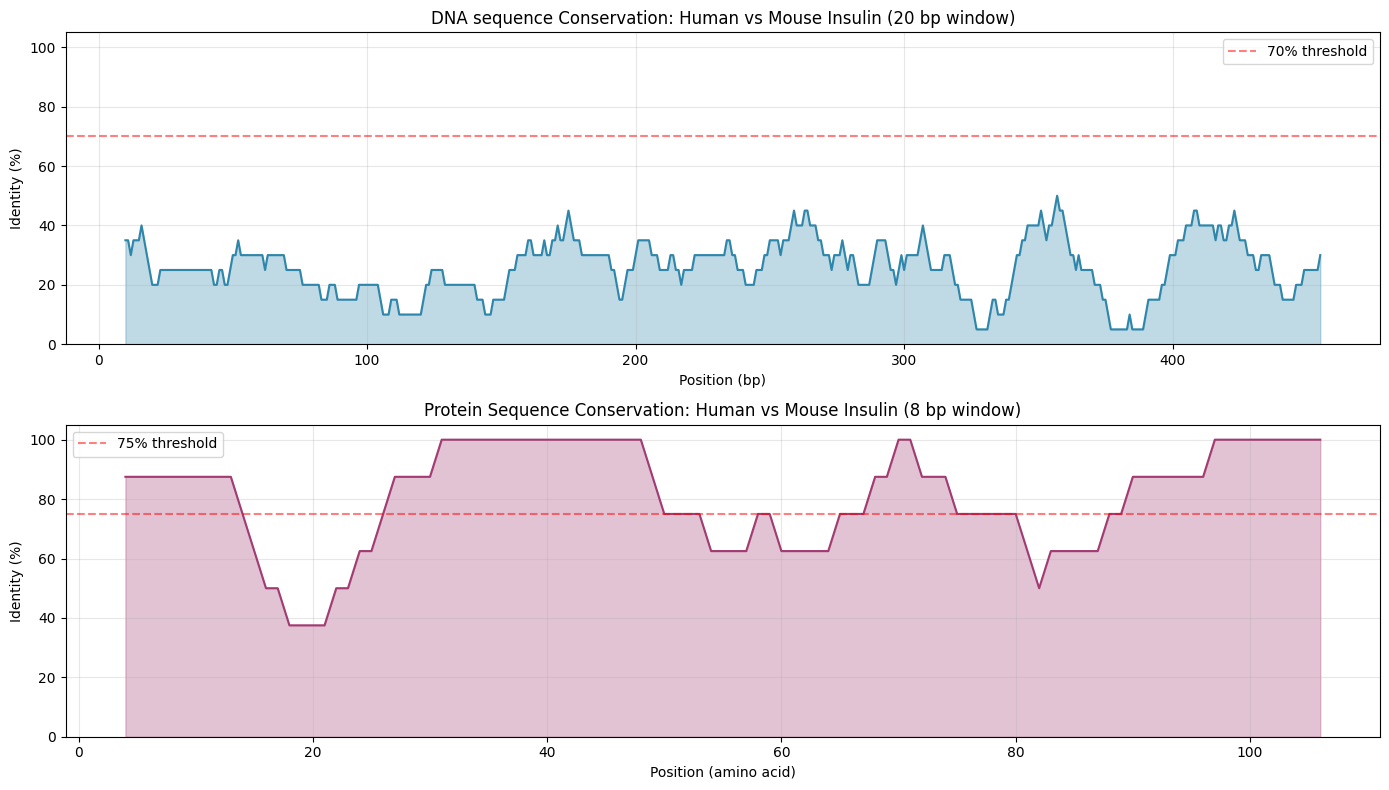

In [67]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# DNA similarity plot
positions_dna, similarities_dna = calculate_sliding_similarity(human_insulin.seq, mouse_insulin.seq, window_size=20)
ax1.plot(positions_dna, similarities_dna, linewidth=1.5, color='#2E86AB')
ax1.fill_between(positions_dna, similarities_dna, alpha=0.3, color='#2E86AB')
ax1.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='70% threshold')
ax1.set_xlabel('Position (bp)')
ax1.set_ylabel('Identity (%)')
ax1.set_title('DNA sequence Conservation: Human vs Mouse Insulin (20 bp window)')
ax1.grid(alpha=0.3)
ax1.legend()
ax1.set_ylim(0, 105)

# Protein similarity plot
positions_prot, similarities_prot = calculate_sliding_similarity(human_protein, mouse_protein, window_size=8)
ax2.plot(positions_prot, similarities_prot, linewidth=1.5, color='#A23B72')
ax2.fill_between(positions_prot, similarities_prot, alpha=0.3, color='#A23B72')
ax2.axhline(y=75, color='red', linestyle='--', alpha=0.5, label='75% threshold')
ax2.set_xlabel('Position (amino acid)')
ax2.set_ylabel('Identity (%)')
ax2.set_title('Protein Sequence Conservation: Human vs Mouse Insulin (8 bp window)')
ax2.grid(alpha=0.3)
ax2.legend()
ax2.set_ylim(0, 105)

plt.tight_layout()
plt.savefig('sequence_conservation_analysis.png', dpi=300)
plt.show()

### Blast Search

In [68]:
from Bio.Blast import NCBIWWW, NCBIXML
import time

In [70]:
# Take human insulin protein for BLAST search
try:
    result_handle = NCBIWWW.qblast(
        program='blastp',
        database='nr',
        sequence=str(human_protein),
        expect=0.001,
        hitlist_size=20
    )

    # Save raw BLAST results
    with open('blast_results.xml', 'w') as file:
        file.write(result_handle.read())
    result_handle.close()
except Exception as e:
    print(f"Error: {e}")

In [72]:
try:
    # Parse BLAST Results
    with open('blast_results.xml') as result_handle:
        blast_records = NCBIXML.parse(result_handle)
        blast_record = next(blast_records)

    print(f"Query: {blast_record.query}")
    print(f"Query Length: {blast_record.query_length} aa")
    print(f"Database: {blast_record.database}")
    print(f"Number of hits: {len(blast_record.alignments)}")

    # Analyze top hits
    blast_results = []
    for i, alignment in enumerate(blast_record.alignments[:10], 1):
        hsp = alignment.hsps[0]     # Best high-scoring pair

        # Calculate identity percentage
        identity_pct = (hsp.identities / hsp.align_length) * 100
        coverage = (hsp.align_length / blast_record.query_length) * 100

        result = {
            'rank': i,
            'title': alignment.title[:80],
            'length': alignment.length,
            'e_value': hsp.expect,
            'score': hsp.score,
            'identities': hsp.identities,
            'positives': hsp.positives,
            'gaps': hsp.gaps,
            'identity_pct': identity_pct,
            'coverage': coverage
        }

        blast_results.append(result)

        print(f"\n{i}. {alignment.title[:80]}")
        print(f"   Length: {alignment.length} aa")
        print(f"   E-value: {hsp.expect:.2e}")
        print(f"   Score: {hsp.score}")
        print(f"   Identity: {hsp.identities}/{hsp.align_length} ({identity_pct:.1f}%)")
        print(f"   Positives: {hsp.positives}/{hsp.align_length} ({(hsp.positives/hsp.align_length)*100:.1f}%)")
        print(f"   Gaps: {hsp.gaps}/{hsp.align_length}")
        print(f"   Query coverage: {coverage:.1f}%")

    # Show alignment for top hit
    if blast_record.alignments:
        top_alignment = blast_record.alignments[0]
        top_hsp = top_alignment.hsps[0]

        print(f"\nQuery: {top_hsp.query[:80]}")
        print(f"       {top_hsp.match[:80]}")
        print(f"Sbjct: {top_hsp.sbjct[:80]}")

        if len(top_hsp.query) > 80:
            print("       ... (truncated)")

except FileNotFoundError:
    print("BLAST results file not found")
except Exception as e:
    print(f"Error parsing BLAST results: {e}")

Query: unnamed protein product
Query Length: 110 aa
Database: nr
Number of hits: 20

1. gb|QMS45324.1| insulin isoform UB [Homo sapiens]
   Length: 153 aa
   E-value: 1.03e-73
   Score: 577.0
   Identity: 110/110 (100.0%)
   Positives: 110/110 (100.0%)
   Gaps: 0/110
   Query coverage: 100.0%

2. ref|XP_004050475.2| insulin isoform X1 [Gorilla gorilla gorilla]
   Length: 153 aa
   E-value: 1.11e-73
   Score: 576.0
   Identity: 110/110 (100.0%)
   Positives: 110/110 (100.0%)
   Gaps: 0/110
   Query coverage: 100.0%

3. gb|AAP36446.1| Homo sapiens insulin, partial [synthetic construct] >gb|AAX29480.
   Length: 111 aa
   E-value: 2.50e-73
   Score: 570.0
   Identity: 110/110 (100.0%)
   Positives: 110/110 (100.0%)
   Gaps: 0/110
   Query coverage: 100.0%

4. ref|NP_000198.1| insulin preproprotein [Homo sapiens] >ref|NP_001172026.1| insul
   Length: 110 aa
   E-value: 3.12e-73
   Score: 569.0
   Identity: 110/110 (100.0%)
   Positives: 110/110 (100.0%)
   Gaps: 0/110
   Query coverage: 100

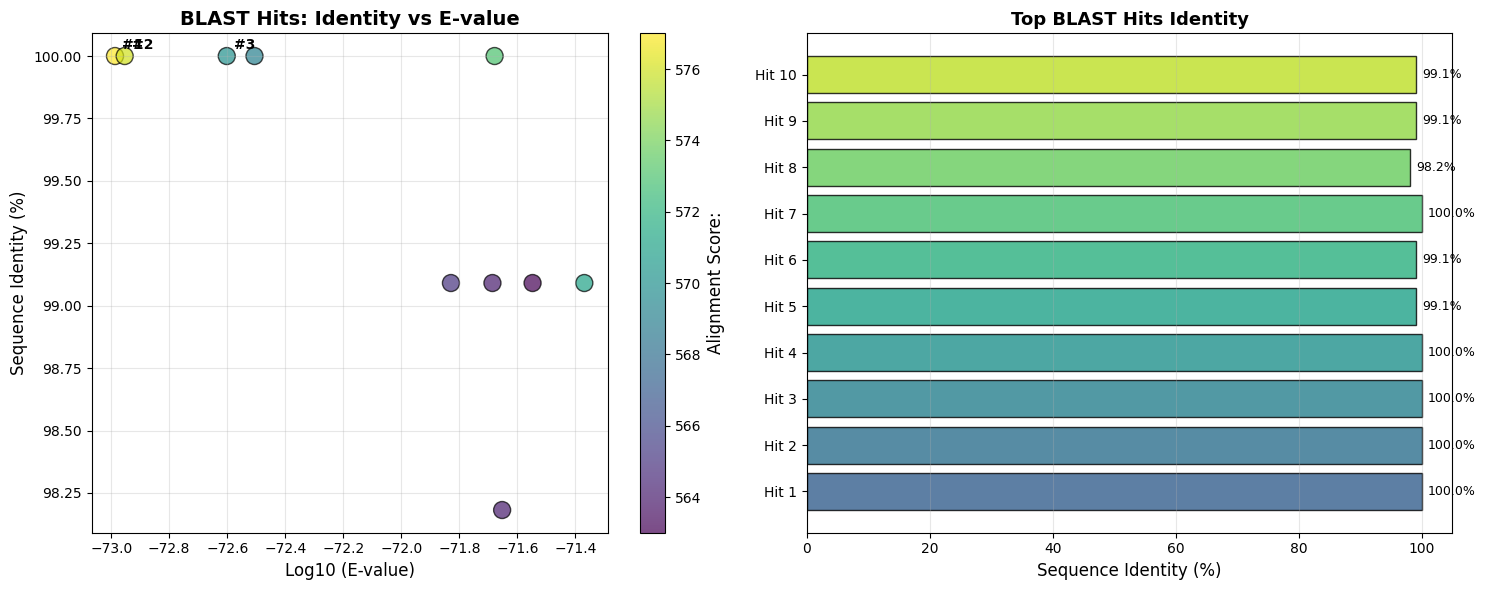

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Identity vs E-value
identities = [r['identity_pct'] for r in blast_results]
e_values = [np.log10(r['e_value']) if r['e_value'] > 0 else -180 for r in blast_results]
scores = [r['score'] for r in blast_results]

scatter = ax1.scatter(e_values, identities, c=scores, s=150, cmap='viridis', alpha=0.7, edgecolors='black', linewidth=1)
ax1.set_xlabel('Log10 (E-value)', fontsize=12)
ax1.set_ylabel('Sequence Identity (%)', fontsize=12)
ax1.set_title('BLAST Hits: Identity vs E-value', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Alignment Score:', fontsize=12)

# Annotate top 3 hits
for i in range(min(3, len(blast_results))):
    ax1.annotate(f"#{i+1}", (e_values[i], identities[i]), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

# Plot 2: COverage vs Identity
coverages = [r['coverage'] for r in blast_results]

bars = ax2.barh(range(len(blast_results)), identities, color=plt.cm.viridis(np.linspace(0.3, 0.9, len(blast_results))), alpha=0.8, edgecolor='black')

ax2.set_yticks(range(len(blast_results)))
ax2.set_yticklabels(f"Hit {i+1}" for i in range(len(blast_results)))
ax2.set_xlabel('Sequence Identity (%)', fontsize=12)
ax2.set_title('Top BLAST Hits Identity', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.set_xlim(0, 105)

# Add values on bar
for i, (bar, identity) in enumerate(zip(bars, identities)):
    ax2.text(identity + 1, i, f'{identity:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('blast_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Phylogenetic Trees

### Collect Multiple Sequences for Phylogenetic Analysis

In [75]:
from Bio import Entrez, SeqIO, AlignIO, Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

In [76]:
# Insulin sequences from different species
species_data = {
    'Human': 'NM_000207',
    'Mouse': 'NM_008387',
    'Rat': 'NM_019130',
    'Dog': 'NM_001003219',
    'Cow': 'NM_173979',
    'Chicken': 'NM_205222',
}

In [77]:
print("Downloading insulin sequences from multiple species...")
sequences = {}

for species, accession in species_data.items():
    try:
        handle = Entrez.efetch(db="nucleotide", id=accession, rettype="fasta", retmode="text")
        record = SeqIO.read(handle, "fasta")
        handle.close()
        
        # Rename for clarity
        record.id = species
        record.description = f"{species} insulin"
        sequences[species] = record
        
        print(f"✓ {species}: {accession} ({len(record.seq)} bp)")
    except Exception as e:
        print(f"✗ {species}: Error - {e}")

# Save sequences to a single FASTA file
SeqIO.write(sequences.values(), "insulin_sequences.fasta", "fasta")
print(f"\nSaved {len(sequences)} sequences to 'insulin_sequences.fasta'")

✓ Human: NM_000207 (465 bp)
✓ Mouse: NM_008387 (485 bp)
✓ Rat: NM_019130 (464 bp)
✓ Dog: NM_001003219 (2137 bp)
✓ Cow: NM_173979 (1948 bp)
✓ Chicken: NM_205222 (525 bp)

Saved 6 sequences to 'insulin_sequences.fasta'


In [78]:
from Bio.SeqRecord import SeqRecord

protein_records = []
for species, record in sequences.items():
    protein = get_longest_orf_protein(record)
    if protein:
        # Create new record for protein
        prot_record = SeqRecord(protein, id=species, description=f"{species} insulin protein")
        protein_records.append(prot_record)
        print(f"{species}: {len(protein)} amino acids")

# Save protein sequences
SeqIO.write(protein_records, "insulin_proteins.fasta", "fasta")
print("\nProtein sequences saved to insulin_proteins.fasta")

Human: 110 amino acids
Mouse: 110 amino acids
Rat: 110 amino acids
Dog: 704 amino acids
Cow: 375 amino acids
Chicken: 107 amino acids

Protein sequences saved to insulin_proteins.fasta


c:\Users\shres\Projects\BioPy\.venv\Lib\site-packages\Bio\Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


### Multiple Sequence Alignment

In [79]:
from Bio.Align import MultipleSeqAlignment
from Bio import pairwise2

In [80]:
# Perform progressive alignment (simple implementation)
# For production, you'd use MUSCLE, MAFFT or Clustal Omega

def progressive_alignment(sequences):
    """Simple progressive alignments"""
    if len(sequences) < 2:
        return sequences
    
    # Start with first wo sequences
    alignments = pairwise2.align.globalxx(sequences[0].seq, sequences[1].seq, one_alignment_only=True)
    if not alignments:
        return sequences
    
    aligned = [
        SeqRecord(Seq(alignments[0].seqA), id=sequences[0].id, description=""),
        SeqRecord(Seq(alignments[0].seqB), id=sequences[1].id, description=""),
    ]

    # Add remaining sequences one-by-one
    for seq_record in sequences[2:]:
        # Align to consensus
        consensus = str(aligned[0].seq)
        new_alignments = pairwise2.align.globalxx(consensus, seq_record.seq, one_alignment_only=True)
        if new_alignments:
            aligned.append(SeqRecord(Seq(new_alignments[0].seqB), id=seq_record.id, description=""))

    return aligned

In [81]:
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

In [82]:
aligned_sequences = progressive_alignment(protein_records)

print(f"Aligned {len(aligned_sequences)} sequences")
print("\nAlignment preview (first 80 positions):")
for record in aligned_sequences:
    print(f"{record.id:10s}: {str(record.seq)[:80]}")

# Save aligned sequences
SeqIO.write(aligned_sequences, "insulin_aligned.fasta", "fasta")
print("\nAligned sequences saved to 'insulin_aligned.fasta'")

Aligned 6 sequences

Alignment preview (first 80 positions):
Human     : MALWMRL-LPLLALLA-LWGPD---PAA--AFVN-QHLCGSHLVEALYLVCGERGFFYTPKT--RREA-EDL-QVG-QV-
Mouse     : MALWMR-FLPLLALL-FLW---ESHP--TQAFV-KQHLCGSHLVEALYLVCGERGFFYTP--MSRRE-VED-PQV-AQ-L
Rat       : MALW-IR--FLPLLALL--ILW-EP----RP-A--QAFV--KQHLCGSHLVEALYLVCGERGFFYTP----MSRRE--VE
Dog       : ----MSPRQPL-VLVFLVLGCCSAAPRPHKPTVVVFPGDLRTNLTDKQLAEEYLFRYGYTQVAELSDDKQSLSRGLRLLQ
Cow       : MDDDIAAL-VVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGIL-TLKYP-IEHGIVT
Chicken   : MALW-IR--SLPLLA-L--L-VFSG-----PGTSYAA--A--N-QHLCGSHLVEALYLVCGERGFFY-SPK---ARR---

Aligned sequences saved to 'insulin_aligned.fasta'


### Calculate Distance Matrix

In [83]:
def calculate_distance_matrix(aligned_seqs):
    """Calculate pairwise distance matrix"""
    n = len(aligned_seqs)
    matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            seq1 = str(aligned_seqs[i].seq).replace('-', '')
            seq2 = str(aligned_seqs[j].seq).replace('-', '')

            # Calculate identity
            min_len = min(len(seq1), len(seq2))
            if min_len > 0:
                matches = sum(1 for a, b in zip(seq1[:min_len], seq2[:min_len]) if a == b and a != '-')
                identity = matches / min_len
                distance = 1 - identity
            else:
                distance = 1.0

            matrix[i][j] = distance
            matrix[j][i] = distance

    return matrix

In [85]:
distance_matrix = calculate_distance_matrix(aligned_sequences)
distance_matrix

array([[0.        , 0.18181818, 0.17272727, 0.87272727, 0.91818182,
        0.53271028],
       [0.18181818, 0.        , 0.05454545, 0.90909091, 0.94545455,
        0.54205607],
       [0.17272727, 0.05454545, 0.        , 0.90909091, 0.92727273,
        0.51401869],
       [0.87272727, 0.90909091, 0.90909091, 0.        , 0.928     ,
        0.92523364],
       [0.91818182, 0.94545455, 0.92727273, 0.928     , 0.        ,
        0.93457944],
       [0.53271028, 0.54205607, 0.51401869, 0.92523364, 0.93457944,
        0.        ]])

In [86]:
species_names = [record.id for record in aligned_sequences]

In [88]:
print("Pairwise Distance Matrix:")
print(f"{'':10s}", end='')
for name in species_names:
    print(f"{name:10s}", end='')
print()

for i, name in enumerate(species_names):
    print(f"{name:10s}", end='')
    for j in range(len(species_names)):
        print(f"{distance_matrix[i][j]:10.4f}", end='')
    print()

Pairwise Distance Matrix:
          Human     Mouse     Rat       Dog       Cow       Chicken   
Human         0.0000    0.1818    0.1727    0.8727    0.9182    0.5327
Mouse         0.1818    0.0000    0.0545    0.9091    0.9455    0.5421
Rat           0.1727    0.0545    0.0000    0.9091    0.9273    0.5140
Dog           0.8727    0.9091    0.9091    0.0000    0.9280    0.9252
Cow           0.9182    0.9455    0.9273    0.9280    0.0000    0.9346
Chicken       0.5327    0.5421    0.5140    0.9252    0.9346    0.0000


### Construct the Phylogenetic Tree (UPGMA)

In [97]:
def upgma(distance_matrix, labels):
    """UPGMA clustering algorithm"""
    n = len(labels)

    # Create initial clusters
    clusters = {i: [labels[i]] for i in range(n)}
    heights = {i: 0.0 for i in range(n)}

    # Distance matrix (make a copy)
    dm = {i: {j: distance_matrix[i, j] for j in range(n)} for i in range(n)}

    tree_structure = []
    cluster_id = n

    while len(clusters) > 1:
        # Find minimum distance
        min_dist = float('inf')
        min_i, min_j = 0, 1

        active_clusters = list(clusters.keys())
        for i in range(len(active_clusters)):
            for j in range(i+1, len(active_clusters)):
                idx_i = active_clusters[i]
                idx_j = active_clusters[j]
                if dm[idx_i][idx_j] < min_dist:
                    min_dist = dm[idx_i][idx_j]
                    min_i, min_j = idx_i, idx_j

        # Merge Clusters
        new_height = min_dist / 2
        tree_structure.append({
            'id': cluster_id,
            'left': min_i,
            'right': min_j,
            'distance': min_dist,
            'height': new_height,
            'members': clusters[min_i] + clusters[min_j]
        })

        # Create new cluster
        clusters[cluster_id] = clusters[min_i] + clusters[min_j]
        heights[cluster_id] = new_height

        # Update distance matrix (average linkage)
        dm[cluster_id] = {}
        for k in clusters.keys():
            if k != min_i and k != min_j and k != cluster_id:
                new_dist = (dm[min_i][k] * len(clusters[min_i]) + dm[min_j][k] * len(clusters[min_j])) / len(clusters[cluster_id])
                dm[cluster_id][k] = new_dist
                dm[k][cluster_id] = new_dist

        # Remove old clusters
        del clusters[min_i]
        del clusters[min_j]

        cluster_id += 1

    return tree_structure

In [99]:
tree = upgma(distance_matrix, species_names)
tree

[{'id': 6,
  'left': 1,
  'right': 2,
  'distance': np.float64(0.054545454545454564),
  'height': np.float64(0.027272727272727282),
  'members': ['Mouse', 'Rat']},
 {'id': 7,
  'left': 0,
  'right': 6,
  'distance': np.float64(0.17727272727272725),
  'height': np.float64(0.08863636363636362),
  'members': ['Human', 'Mouse', 'Rat']},
 {'id': 8,
  'left': 5,
  'right': 7,
  'distance': np.float64(0.5295950155763239),
  'height': np.float64(0.26479750778816197),
  'members': ['Chicken', 'Human', 'Mouse', 'Rat']},
 {'id': 9,
  'left': 3,
  'right': 8,
  'distance': np.float64(0.904035683942226),
  'height': np.float64(0.452017841971113),
  'members': ['Dog', 'Chicken', 'Human', 'Mouse', 'Rat']},
 {'id': 10,
  'left': 4,
  'right': 9,
  'distance': np.float64(0.9306977060322856),
  'height': np.float64(0.4653488530161428),
  'members': ['Cow', 'Dog', 'Chicken', 'Human', 'Mouse', 'Rat']}]

### Visualize the Phylogenetic Tree

In [102]:
def plot_phylogenetic_tree(tree_structure, labels):
    """Plot a phylogenetic tree"""
    fig, ax = plt.subplots(figsize=(12, 8))

    # Calculate leaf positions
    n_leaves = len(labels)
    leaf_positions = {i: i for i in range(n_leaves)}
    node_positions = {}

    # Calculate node positions
    for node in tree_structure:
        left_idx = node['left']
        right_idx = node['right']

        # Get y-position
        if left_idx < n_leaves:
            left_y = leaf_positions[left_idx]
        else:
            left_y = node_positions[left_idx][1]
        
        if right_idx < n_leaves:
            right_y = leaf_positions[right_idx]
        else:
            right_y = node_positions[right_idx][1]

        # New node position
        y_pos = (left_y + right_y) / 2
        x_pos = node['height']
        node_positions[node['id']] = (x_pos, y_pos)

        # Draw branches
        # Get x positions for the children
        left_x = 0 if left_idx < n_leaves else node_positions[left_idx][0]
        right_x = 0 if right_idx < n_leaves else node_positions[right_idx][0]

        # Vertical Line
        ax.plot([x_pos, x_pos], [left_y, right_y], 'k-', linewidth=2)

        # Horizontal Line
        ax.plot([left_x, x_pos], [left_y, left_y], 'k-', linewidth=2)
        ax.plot([right_x, x_pos], [right_y, right_y], 'k-', linewidth=2)

    # Add labels
    for i, label in enumerate(labels):
        ax.text(-0.01, i, label, ha='right', va='center', fontsize=11, fontweight='bold')

    ax.set_ylim(-0.5, n_leaves - 0.5)
    ax.set_xlim(-0.05, max(node['height'] for node in tree_structure) * 1.1)
    ax.set_xlabel('Evolutionary Distance', fontsize=12)
    ax.set_title('Phylogenetic Tree of Insulin Genes (UPGMA)', fontsize=14, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('phylogenetic_tree.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig, ax

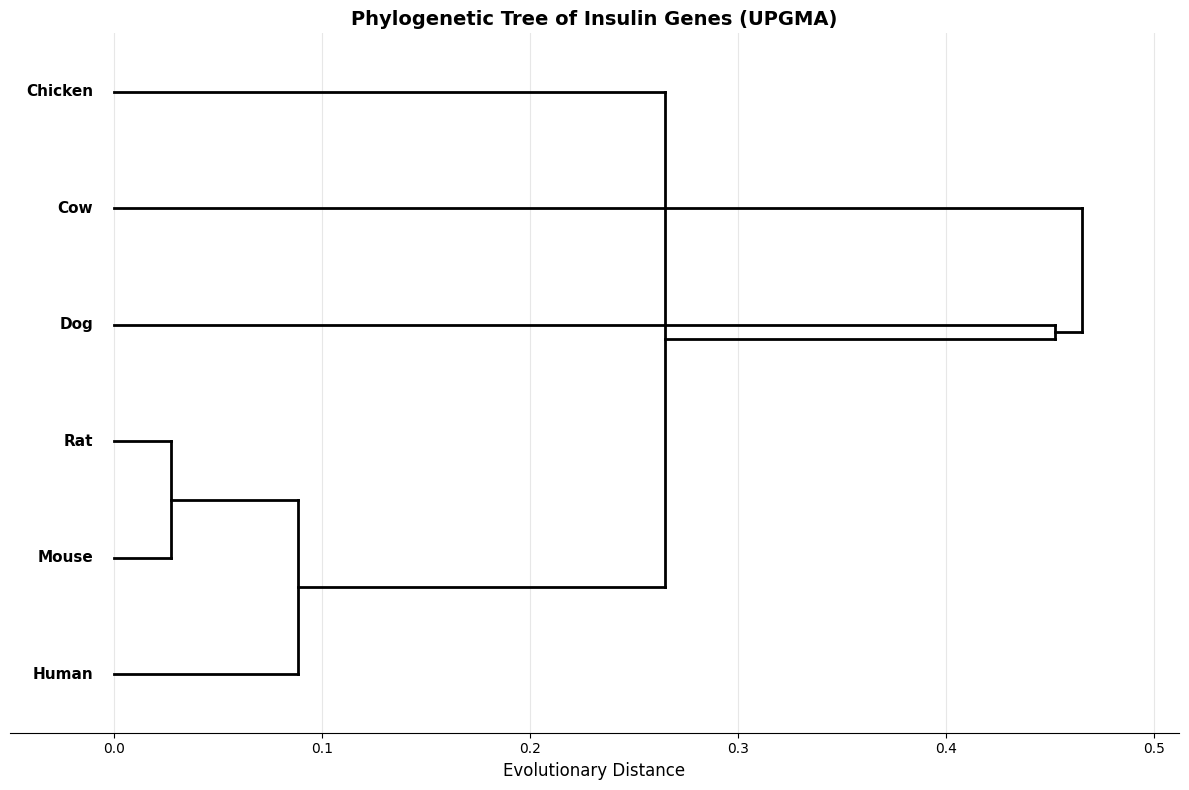

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Phylogenetic Tree of Insulin Genes (UPGMA)'}, xlabel='Evolutionary Distance'>)

In [103]:
plot_phylogenetic_tree(tree, species_names)

## AI/ML in Bioinformatics

### Sequence Classification with ML

In [14]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [15]:
# Function to extract features from protein sequences
def extract_protein_features(sequence):
    """Extract numerical features from protein sequence"""
    seq_str = str(sequence).replace('*', '')    # Remove stop codons

    if len(seq_str) == 0:
        return None
    
    try:
        analyzer = ProteinAnalysis(seq_str)

        # Get amino acid composition
        aa_comp = analyzer.get_amino_acids_percent()

        secondary_structure_fractions = analyzer.secondary_structure_fraction()

        features = {
            'length': len(seq_str),
            'molecular_weight': analyzer.molecular_weight(),
            'aromaticity': analyzer.aromaticity(),
            'instability_index': analyzer.instability_index(),
            'isoelectric_point': analyzer.isoelectric_point(),
            'helix_fraction': secondary_structure_fractions[0],
            'turn_fraction': secondary_structure_fractions[1],
            'sheet_fraction': secondary_structure_fractions[2],
        }

        # Add amino acid percentages
        for aa, percent in aa_comp.items():
            features[f'aa_{aa}'] = percent
        
        return features
    except:
        return None

In [16]:
# Collect Positive Samples (insulin proteins)
insulin_ids = ['NM_000207', 'NM_008387', 'NM_019130', 'NM_001003219', 'NM_173979', 'NM_205222', 'XM_005617290', 'XM_003127682']

In [17]:
from Bio import Entrez, SeqIO

In [ ]:
Entrez.email = "you@email.com"

In [19]:
positive_features = []

print("\nCollecting insulin sequences (positive samples)...")
for acc_id in insulin_ids:
    try:
        handle = Entrez.efetch(db='nucleotide', id=acc_id, rettype='fasta', retmode='text')
        record = SeqIO.read(handle, 'fasta')
        handle.close()

        # Translate to protein
        protein = record.seq.translate()
        features = extract_protein_features(protein)

        if features:
            features['label'] = 1   # Insulin
            features['protein_name'] = 'insulin'
            positive_features.append(features)
            print(f"☑️ {acc_id}")
    except:
        print(f"❌ {acc_id} - failed")

c:\Users\shres\Projects\BioPy\.venv\Lib\site-packages\Bio\SeqUtils\ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(


☑️ NM_000207


c:\Users\shres\Projects\BioPy\.venv\Lib\site-packages\Bio\Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


☑️ NM_008387
☑️ NM_019130
☑️ NM_001003219
☑️ NM_173979
☑️ NM_205222
☑️ XM_005617290
☑️ XM_003127682


In [20]:
positive_features

[{'length': 151,
  'molecular_weight': 16376.348,
  'aromaticity': 0.07947019867549669,
  'instability_index': 71.64304635761592,
  'isoelectric_point': 9.297904396057131,
  'helix_fraction': 0.2384105960264901,
  'turn_fraction': 0.34437086092715236,
  'sheet_fraction': 0.25165562913907286,
  'aa_A': 0.13907284768211922,
  'aa_C': 0.06622516556291391,
  'aa_D': 0.006622516556291392,
  'aa_E': 0.033112582781456956,
  'aa_F': 0.0,
  'aa_G': 0.05298013245033113,
  'aa_H': 0.019867549668874173,
  'aa_I': 0.013245033112582783,
  'aa_K': 0.013245033112582783,
  'aa_L': 0.04635761589403973,
  'aa_M': 0.006622516556291392,
  'aa_N': 0.026490066225165566,
  'aa_P': 0.152317880794702,
  'aa_Q': 0.04635761589403973,
  'aa_R': 0.07947019867549669,
  'aa_S': 0.10596026490066227,
  'aa_T': 0.08609271523178809,
  'aa_V': 0.026490066225165566,
  'aa_W': 0.07947019867549669,
  'aa_Y': 0.0,
  'label': 1,
  'protein_name': 'insulin'},
 {'length': 156,
  'molecular_weight': 15953.0045,
  'aromaticity': 0

In [23]:
# Collect negative samples (other hormone proteins)
non_insulin_ids = ['NM_000516', 'NM_000520', 'NM_001270', 'NM_000515', 'NM_001282409', 'NM_001282866', 'NM_000518', 'NM_006211']

In [24]:
negative_features = []

for acc_id in non_insulin_ids:
    try:
        handle = Entrez.efetch(db='nucleotide', id=acc_id, rettype='fasta', retmode='text')
        record = SeqIO.read(handle, "fasta")
        handle.close()

        protein = record.seq.translate()
        features = extract_protein_features(protein)

        if features:
            features['label'] = 0   # Not insulin
            features['protein_name'] = 'other hormone'
            negative_features.append(features)
            print(f"☑️ {acc_id}")
    except:
        print(f"❌ {acc_id} - failed")

☑️ NM_000516
☑️ NM_000520
☑️ NM_001270
☑️ NM_000515
☑️ NM_001282409
☑️ NM_001282866
☑️ NM_000518
☑️ NM_006211


In [26]:
negative_features

[{'length': 604,
  'molecular_weight': 68447.1825,
  'aromaticity': 0.07615894039735101,
  'instability_index': 57.32253311258293,
  'isoelectric_point': 9.518966484069825,
  'helix_fraction': 0.326158940397351,
  'turn_fraction': 0.28807947019867547,
  'sheet_fraction': 0.2847682119205298,
  'aa_A': 0.09271523178807946,
  'aa_C': 0.018211920529801324,
  'aa_D': 0.049668874172185434,
  'aa_E': 0.06953642384105961,
  'aa_F': 0.043046357615894044,
  'aa_G': 0.04635761589403973,
  'aa_H': 0.019867549668874173,
  'aa_I': 0.048013245033112585,
  'aa_K': 0.076158940397351,
  'aa_L': 0.07450331125827814,
  'aa_M': 0.013245033112582783,
  'aa_N': 0.05132450331125828,
  'aa_P': 0.08112582781456953,
  'aa_Q': 0.05298013245033113,
  'aa_R': 0.08443708609271523,
  'aa_S': 0.059602649006622516,
  'aa_T': 0.03642384105960265,
  'aa_V': 0.049668874172185434,
  'aa_W': 0.006622516556291392,
  'aa_Y': 0.026490066225165566,
  'label': 0,
  'protein_name': 'other hormone'},
 {'length': 1559,
  'molecular

In [25]:
import pandas as pd

In [27]:
all_features = positive_features + negative_features
df = pd.DataFrame(all_features)
df

,length,molecular_weight,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,sheet_fraction,aa_A,aa_C,...,aa_P,aa_Q,aa_R,aa_S,aa_T,aa_V,aa_W,aa_Y,label,protein_name
0,151,16376.3480,0.079470,71.643046,9.297904,0.238411,0.344371,0.251656,0.139073,0.066225,...,0.152318,0.046358,0.079470,0.105960,0.086093,0.026490,0.079470,0.000000,1,insulin
1,156,15953.0045,0.051282,60.275000,7.248358,0.275641,0.435897,0.301282,0.083333,0.019231,...,0.166667,0.038462,0.025641,0.083333,0.057692,0.038462,0.032051,0.000000,1,insulin
2,152,16983.4912,0.078947,50.488224,8.713627,0.348684,0.236842,0.322368,0.092105,0.046053,...,0.065789,0.072368,0.052632,0.046053,0.032895,0.059211,0.013158,0.032895,1,insulin
3,711,79008.4537,0.120956,39.075682,5.421610,0.223629,0.333333,0.362869,0.060478,0.026723,...,0.091421,0.037975,0.061885,0.049226,0.087201,0.061885,0.018284,0.037975,1,insulin
4,624,68787.5876,0.088141,78.645673,11.781227,0.251603,0.357372,0.283654,0.076923,0.044872,...,0.139423,0.014423,0.105769,0.147436,0.086538,0.028846,0.035256,0.003205,1,insulin
5,171,18746.3340,0.116959,55.923450,8.628400,0.315789,0.327485,0.345029,0.105263,0.035088,...,0.105263,0.040936,0.052632,0.105263,0.040936,0.017544,0.052632,0.017544,1,insulin
6,552,62757.0452,0.092391,79.552355,10.468844,0.259058,0.317029,0.302536,0.068841,0.043478,...,0.063406,0.047101,0.105072,0.141304,0.063406,0.030797,0.056159,0.019928,1,insulin
7,623,64913.9179,0.062600,64.708186,7.333219,0.284109,0.390048,0.261637,0.099518,0.036918,...,0.146067,0.051364,0.048154,0.107544,0.032103,0.043339,0.022472,0.016051,1,insulin
8,604,68447.1825,0.076159,57.322533,9.518966,0.326159,0.288079,0.284768,0.092715,0.018212,...,0.081126,0.052980,0.084437,0.059603,0.036424,0.049669,0.006623,0.026490,0,other hormone
9,1559,175591.3942,0.118024,49.787216,8.774228,0.262989,0.306607,0.368185,0.056446,0.032713,...,0.078897,0.040411,0.060936,0.086594,0.048749,0.060295,0.028223,0.028865,0,other hormone


In [28]:
print(f"\nDataset created: {len(positive_features)} insulin, {len(negative_features)} non-insulin")
print(f"Total features: {len(df.columns) - 2}")  # Exclude label and protein_name


Dataset created: 8 insulin, 8 non-insulin
Total features: 28


### Train Machine Learning Model

In [29]:
# Prepare data
X = df.drop(['label', 'protein_name'], axis=1)
Y = df['label']

In [30]:
X

,length,molecular_weight,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,sheet_fraction,aa_A,aa_C,...,aa_M,aa_N,aa_P,aa_Q,aa_R,aa_S,aa_T,aa_V,aa_W,aa_Y
0,151,16376.3480,0.079470,71.643046,9.297904,0.238411,0.344371,0.251656,0.139073,0.066225,...,0.006623,0.026490,0.152318,0.046358,0.079470,0.105960,0.086093,0.026490,0.079470,0.000000
1,156,15953.0045,0.051282,60.275000,7.248358,0.275641,0.435897,0.301282,0.083333,0.019231,...,0.006410,0.019231,0.166667,0.038462,0.025641,0.083333,0.057692,0.038462,0.032051,0.000000
2,152,16983.4912,0.078947,50.488224,8.713627,0.348684,0.236842,0.322368,0.092105,0.046053,...,0.019737,0.032895,0.065789,0.072368,0.052632,0.046053,0.032895,0.059211,0.013158,0.032895
3,711,79008.4537,0.120956,39.075682,5.421610,0.223629,0.333333,0.362869,0.060478,0.026723,...,0.007032,0.019691,0.091421,0.037975,0.061885,0.049226,0.087201,0.061885,0.018284,0.037975
4,624,68787.5876,0.088141,78.645673,11.781227,0.251603,0.357372,0.283654,0.076923,0.044872,...,0.019231,0.011218,0.139423,0.014423,0.105769,0.147436,0.086538,0.028846,0.035256,0.003205
5,171,18746.3340,0.116959,55.923450,8.628400,0.315789,0.327485,0.345029,0.105263,0.035088,...,0.005848,0.017544,0.105263,0.040936,0.052632,0.105263,0.040936,0.017544,0.052632,0.017544
6,552,62757.0452,0.092391,79.552355,10.468844,0.259058,0.317029,0.302536,0.068841,0.043478,...,0.027174,0.034420,0.063406,0.047101,0.105072,0.141304,0.063406,0.030797,0.056159,0.019928
7,623,64913.9179,0.062600,64.708186,7.333219,0.284109,0.390048,0.261637,0.099518,0.036918,...,0.004815,0.004815,0.146067,0.051364,0.048154,0.107544,0.032103,0.043339,0.022472,0.016051
8,604,68447.1825,0.076159,57.322533,9.518966,0.326159,0.288079,0.284768,0.092715,0.018212,...,0.013245,0.051325,0.081126,0.052980,0.084437,0.059603,0.036424,0.049669,0.006623,0.026490
9,1559,175591.3942,0.118024,49.787216,8.774228,0.262989,0.306607,0.368185,0.056446,0.032713,...,0.014112,0.030789,0.078897,0.040411,0.060936,0.086594,0.048749,0.060295,0.028223,0.028865


In [31]:
Y

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
Name: label, dtype: int64

In [35]:
# Handle any missing values
X[X.isnull()]

,length,molecular_weight,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,sheet_fraction,aa_A,aa_C,...,aa_M,aa_N,aa_P,aa_Q,aa_R,aa_S,aa_T,aa_V,aa_W,aa_Y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
X.isnull().count()

length               16
molecular_weight     16
aromaticity          16
instability_index    16
isoelectric_point    16
helix_fraction       16
turn_fraction        16
sheet_fraction       16
aa_A                 16
aa_C                 16
aa_D                 16
aa_E                 16
aa_F                 16
aa_G                 16
aa_H                 16
aa_I                 16
aa_K                 16
aa_L                 16
aa_M                 16
aa_N                 16
aa_P                 16
aa_Q                 16
aa_R                 16
aa_S                 16
aa_T                 16
aa_V                 16
aa_W                 16
aa_Y                 16
dtype: int64

In [37]:
X = X.fillna(X.mean())

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=123, stratify=Y)

In [40]:
# Scale features
from sklearn.preprocessing import StandardScaler

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
# Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=123,
    class_weight='balanced'
)

In [44]:
rf_model.fit(X_train_scaled, Y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [45]:
# Make Predictions
Y_pred = rf_model.predict(X_test_scaled)
Y_pred_proba = rf_model.predict_proba(X_test_scaled)

In [46]:
# Evaluate
from sklearn.metrics import classification_report

print("Model Performance:")
print(classification_report(Y_test, Y_pred, target_names=['Non-Insulin', 'Insulin']))


Model Performance:
              precision    recall  f1-score   support

 Non-Insulin       0.50      0.67      0.57         3
     Insulin       0.00      0.00      0.00         2

    accuracy                           0.40         5
   macro avg       0.25      0.33      0.29         5
weighted avg       0.30      0.40      0.34         5



In [47]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

Top 10 Most Important Features:
       feature  importance
          aa_D    0.126240
          aa_V    0.122449
          aa_W    0.079232
          aa_S    0.075714
          aa_P    0.072620
 turn_fraction    0.069234
          aa_C    0.058845
helix_fraction    0.051362
          aa_K    0.049573
          aa_E    0.046771



✓ Classification results saved to 'ml_classification_results.png'


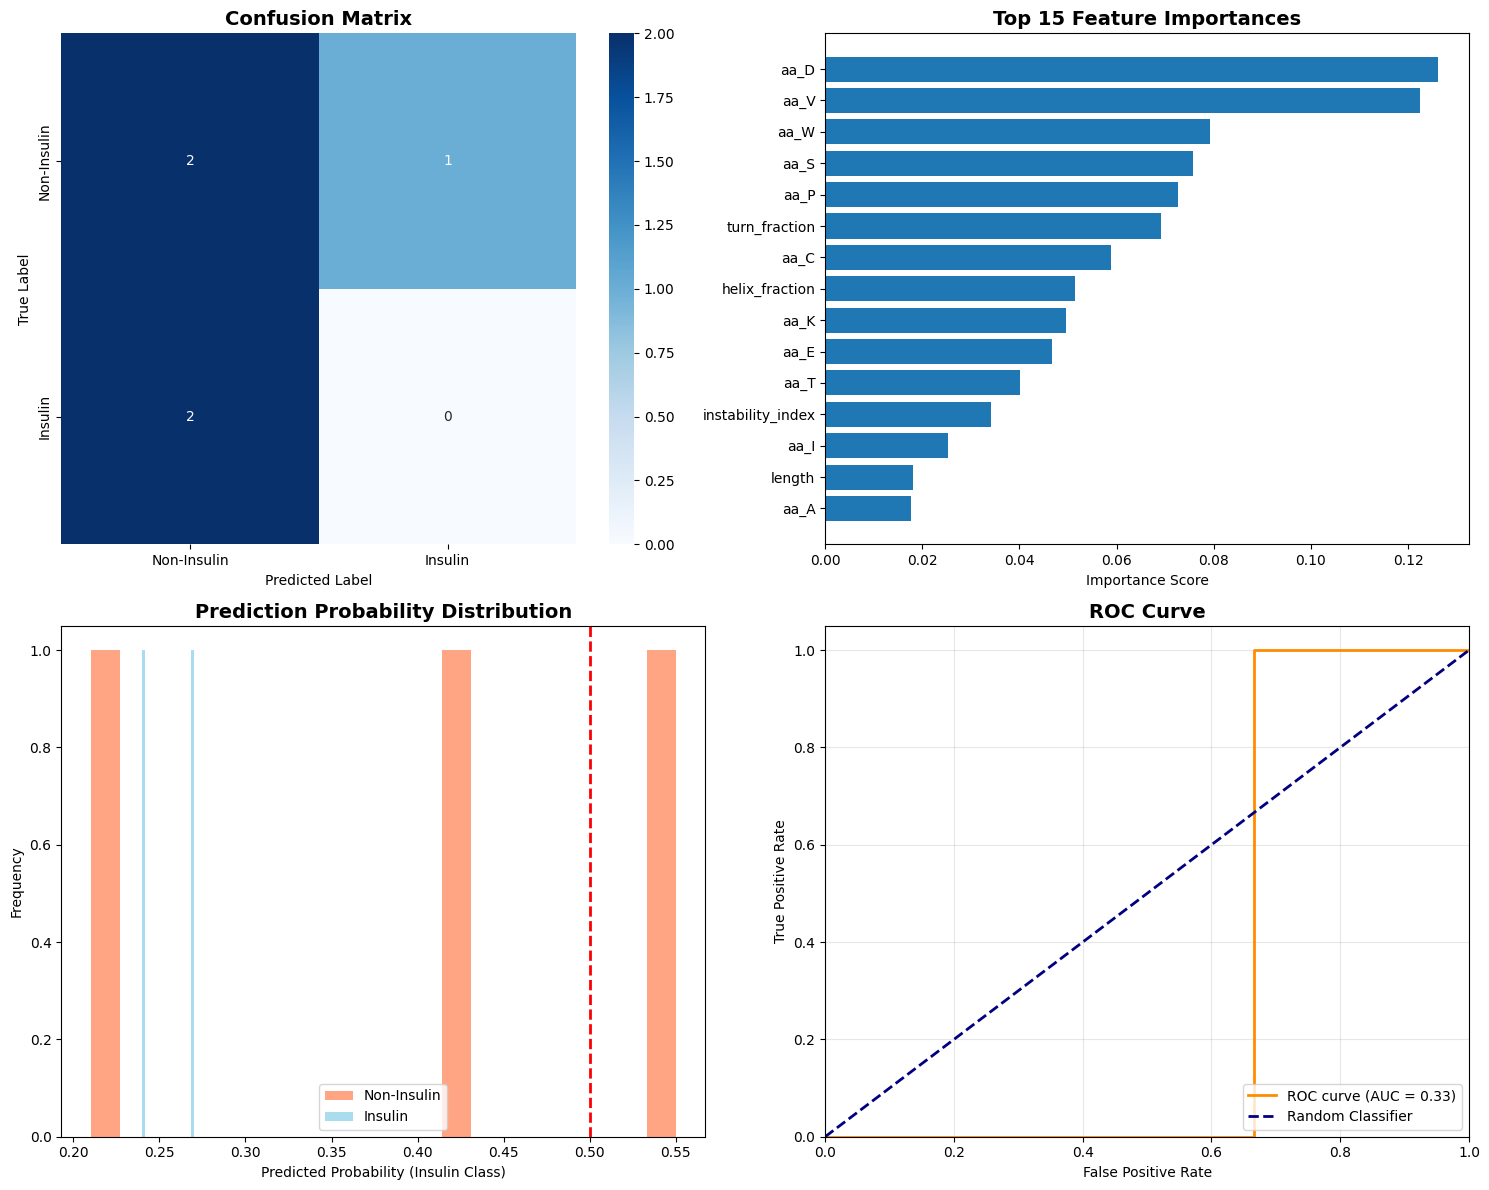

In [49]:
# Visualize Model Performance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')
axes[0, 0].set_xticklabels(['Non-Insulin', 'Insulin'])
axes[0, 0].set_yticklabels(['Non-Insulin', 'Insulin'])

# 2. Feature Importance
top_features = feature_importance.head(15)
axes[0, 1].barh(range(len(top_features)), top_features['importance'])
axes[0, 1].set_yticks(range(len(top_features)))
axes[0, 1].set_yticklabels(top_features['feature'])
axes[0, 1].set_xlabel('Importance Score')
axes[0, 1].set_title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()

# 3. Prediction Probabilities
axes[1, 0].hist(Y_pred_proba[Y_test == 0][:, 1], bins=20, alpha=0.7, label='Non-Insulin', color='coral')
axes[1, 0].hist(Y_pred_proba[Y_test == 1][:, 1], bins=20, alpha=0.7, label='Insulin', color='skyblue')
axes[1, 0].set_xlabel('Predicted Probability (Insulin Class)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Decision Boundary')

# 4. ROC Curve
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

axes[1, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('ml_classification_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Classification results saved to 'ml_classification_results.png'")